# Performing analysis of 1 full second of simulation data acquired using the parameters of the notebook QPsimulation_5_12_2020.ipynb

#### Load the raw real and imaginary data from pickle files and filter for SNR of 50

In [1]:
import pickle

In [2]:
with open(r"E:\QPtrapperData\resParams.pkl",'rb') as f:
    resParams = pickle.load(f)

In [3]:
from scipy.constants import pi
from scipy.signal import windows, convolve

In [177]:
avgTime = 4*resParams['Qt']*50/(resParams['photonRO']*2*pi*resParams['f0'])

###### Let's see how long we're averaging to achieve SNR of 50, note that the time is in units of microseconds

In [178]:
avgTime * 1e6

2.4841055399968073

###### generate a Hann window with length equal to averaging time and convolve with the raw data.

In [6]:
nAvg = int(max(avgTime*resParams['sampleRate'],1))
window = windows.hann(nAvg)

In [7]:
with open(r"E:\QPtrapperData\rawSignalReal.pkl",'rb') as f:
    rhann = convolve(pickle.load(f),window,mode='same')/sum(window)

In [8]:
with open(r"E:\QPtrapperData\rawSignalImag.pkl",'rb') as f:
    ihann = convolve(pickle.load(f),window,mode='same')/sum(window)

### Now we'll visualize the data with a histogram

In [9]:
from matplotlib.pyplot import hist2d, show

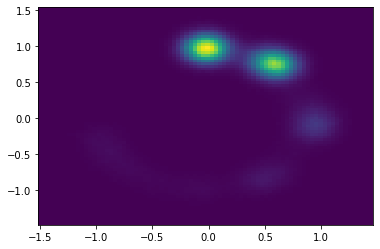

In [10]:
hist2d(rhann,ihann,bins=(80,80));show()

#### Let's look at the individual Traces overs some time period

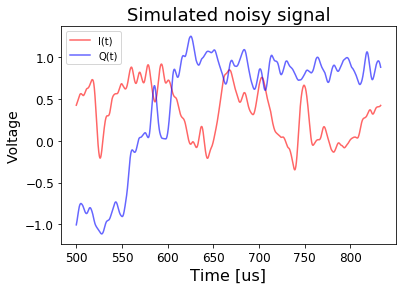

In [137]:
h = plt.subplot()
h.plot(time[150000:250000]*1e6,rhann[150000:250000],'r',alpha=0.6,label='I(t)')
h.plot(time[150000:250000]*1e6,ihann[150000:250000],'b',alpha=0.6,label='Q(t)')
h.set_title('Simulated noisy signal',fontsize = 18)
h.set_xlabel('Time [us]',fontsize = 16)
h.set_ylabel('Voltage',fontsize = 14)
h.tick_params(labelsize=12)
h.legend()
plt.savefig(r'E:\QPtrapperData\noisySignal.svg',format='svg')
plt.show()

### Now we'll use a machine learning package developed by scikit that implements the expectation-maximization algorithm for fitting a mixture of Gaussians.

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
import numpy as np

##### The first time didn't work very well, so I'll try providing it with some initial guess at the means. In the above histogram, we can see that the modes are distributed around the unit circle, so I'll define the estimates with the angle

In [11]:
theta_guess = [np.pi/2,np.pi/3,0,-np.pi/3,-np.pi/2,-2*np.pi/3,7*np.pi/6]
means_guess = np.array([np.cos(theta_guess),np.sin(theta_guess)]).T

In [12]:
estimator = GaussianMixture(n_components = len(means_guess),means_init=means_guess)
estimator.fit(np.array([rhann[:int(rhann.size/10)],ihann[:int(ihann.size/10)]]).T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=array([[ 6.12323400e-17,  1.00000000e+00],
       [ 5.00000000e-01,  8.66025404e-01],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 6.12323400e-17, -1.00000000e+00],
       [-5.00000000e-01, -8.66025404e-01],
       [-8.66025404e-01, -5.00000000e-01]]),
                n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
estimator.converged_

True

In [14]:
estimator.means_

array([[-0.01178793,  0.97636111],
       [ 0.5767587 ,  0.76672258],
       [ 0.93150619, -0.0542127 ],
       [ 0.53364773, -0.78502675],
       [ 0.02457355, -0.94989113],
       [-0.5072886 , -0.83314569],
       [-0.89200591, -0.4149179 ]])

In [14]:
estimator.means_

array([[-0.01319666,  0.97687212],
       [ 0.57501143,  0.76766706],
       [ 0.93082679, -0.05183805],
       [ 0.52619426, -0.78724896],
       [-0.01824205, -0.95682266],
       [-0.51075544, -0.83298652],
       [-0.89050123, -0.42174105]])

#### Let's visualize the results with contours generated by the Gaussian Mixture algorithm. First let's create a mesh with 80 points

In [21]:
x = np.linspace(-1.5,1.5,80)
xx,yy = np.meshgrid(x,x)
positions = np.array([xx.ravel(),yy.ravel()]).T

#### Now we'll have the estimator score the likelyhood that each point defined by positions belongs to a mode.

In [33]:
zz = estimator.score_samples(positions)

In [34]:
zz = zz.reshape(xx.shape)

#### and generate the plots

In [19]:
import matplotlib.pyplot as plt

In [20]:
from matplotlib.colors import LogNorm

### The plot below shows the negative log probability of each point. That is, the higher numbers on the colorbar are less likely than low numbers.

C:\Users\LFL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Log scale: values of z <= 0 have been masked
  """Entry point for launching an IPython kernel.


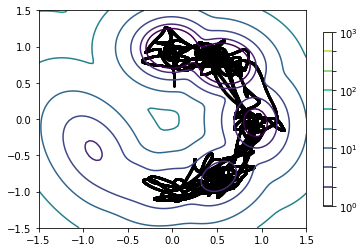

In [37]:
CS = plt.contour(xx,yy,-zz, norm = LogNorm(vmin=1.0,vmax=1000), levels = np.logspace(0,3,10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(rhann[:int(rhann.size/1000)],ihann[:int(ihann.size/1000)],.6,'k')
plt.show()

### Now we plot ellipses showing the means and std. deviations of the 7 modes.

In [138]:
from matplotlib.patches import Ellipse

In [144]:
colors = ['red','orange','yellow','green','blue','indigo','violet']
def make_ellipses(gmm,ax):
    for n, color in enumerate(colors):
        covariances = gmm.covariances_[n][:2,:2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = 180*np.arctan2(u[1],u[0])/np.pi
        v = 2. * np.sqrt(2.)*np.sqrt(v)
        ell = Ellipse(gmm.means_[n,:2],v[0],v[1],180+angle,color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ell.set_label('{} QPs'.format(n))
        ax.add_artist(ell)
        ax.set_aspect('equal','datalim')

No handles with labels found to put in legend.


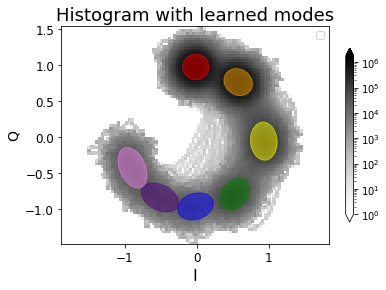

In [145]:
h = plt.subplot()
make_ellipses(estimator,h)
hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
hb = plt.colorbar(hs[-1], shrink=0.8, extend='both')
h.set_title('Histogram with learned modes',fontsize=18)
h.set_xlabel('I',fontsize=16)
h.set_ylabel('Q',fontsize=14)
h.tick_params(labelsize=12)
h.legend()
plt.savefig(r'E:\QPtrapperData\histModes.svg',format='svg')
plt.show()

## Now for the real test. Let's see if it can predict the QP trap state for each point in the dataset

In [15]:
nEst = np.empty(resParams['N'],dtype=int)
seg = int(rhann.size/10)
for i in range(10):
    nEst[i*seg:(i+1)*seg] = estimator.predict(np.transpose((rhann[i*seg:(i+1)*seg],ihann[i*seg:(i+1)*seg])))

#### Let's look at a comparison between the actual number of trapped quasiparticles per the simulation, and the estimated number of trapped quasiparticles.
We first have to import the nTrapped data from pickle file

In [16]:
with open(r"E:\QPtrapperData\nTrapped.pkl",'rb') as f:
    nTrapped = pickle.load(f)

In [17]:
time = np.arange(resParams['N'])/resParams['sampleRate']

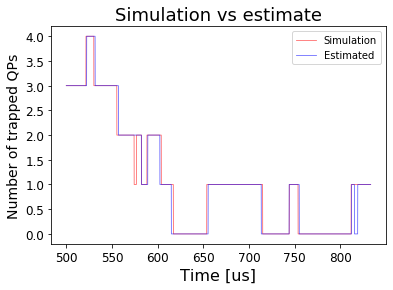

In [153]:
h = plt.subplot()
h.plot(time[150000:250000]*1e6,nTrapped[150000:250000],'r',alpha=0.6,label='Simulation',lw=0.8)
h.plot(time[150000:250000]*1e6,nEst[150000:250000],'b',alpha=0.6,label='Estimated',lw=0.8)
h.set_title('Simulation vs estimate',fontsize = 18)
h.set_xlabel('Time [us]',fontsize = 16)
h.set_ylabel('Number of trapped QPs',fontsize = 14)
h.tick_params(labelsize=12)
h.legend()
plt.savefig(r'E:\QPtrapperData\trapEstimateComparison.svg',format='svg')
plt.show()

#### We can quantify the error by taking the mean of the difference

In [23]:
from numba import cuda

In [24]:
@cuda.jit
def fast_diff(A,B,C):
    pos = cuda.grid(1)
    if pos < C.size:
        C[pos] = B[pos] - A[pos]

In [25]:
nTrapped = np.array(nTrapped,dtype=np.int32)

In [26]:
errTrap = np.empty(resParams['N'],dtype=np.int32)

In [27]:
fast_diff(nEst,nTrapped,errTrap)

CudaAPIError: [2] Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY

#### Speed up with GPU will take more work. not worth it right now. let's just use Numpy to calculate what we need

In [33]:
errTrap = np.diff((nEst,nTrapped),axis=0)[0]

In [34]:
errTrap.shape

(300000000,)

#### errTrap is the difference, errTrap[i] = nTrapped[i] - nEst[i]. It should be positive when we underestimate and negative when we overestimate. The mean should approach 0 for large dataset unless we are somehow more prone to over or under estimating.

In [35]:
np.mean(errTrap)

0.14114806

#### This would imply we are slightly more likely to underestimate. This makes sense because we can only  distinguish up to 5 trapped quasiparticles with  any accuracy. The last gaussian mode will include all occupations of 6 or more QPs. Let's look at the max of each

In [36]:
print('The actual maximum occupation is {}, while our highest occupation mode is {} or more.'.format(np.max(nTrapped),np.max(nEst)))

The actual maximum occupation is 40, while our highest occupation mode is 6 or more.


#### Let's look at the mean again, but this time we'll map the actual occupation to the range [0,6+] so as to match our estimator

In [38]:
errTrap = np.diff((nEst,np.clip(nTrapped,0,6)))[0]

In [39]:
np.mean(errTrap)

3.3333333444444444e-09

#### That's reassuring. Excluding the inability to distinguish high occupations, it looks like we're very close to a symmetric estimation.

##### Ok, now let's quantify the error. The root mean square of the difference should tell us what percent of the time we're wrong about the state.

In [179]:
np.sqrt(np.mean(errTrap**2))*100 

0.799061951370689

#### According to the above, we are off in our estimate 0.0064% of the time. That's pretty low

#### Now let's extract the times between subsequent trapping events and release events

In [43]:
events = np.diff(nEst)

##### Let's see if we have any double trapping or double release eevnts

In [44]:
np.max(events)

2

In [45]:
np.min(events)

-1

##### Ok, we have atleast one double trap event, but no double releases.

In [103]:
T_id = np.where(events == 1)
doubleT_id = np.where(events == 2)
R_id = np.where(events < 0)

### Release statistics are more tricky. In the above, I'm counting all the periods when there are no QPs in the traps. There can be no release in this case, so these periods should be ommitted.

In [223]:
Occupied_id = np.where(nEst > 0)

In [224]:
Tsplit = np.split(time,Occupied_id[0]+1)

MemoryError: 

In [108]:
len(doubleT_id)

1

#### There was only one double trapping event, safe to ignore.

In [104]:
T_waits = np.diff(time[T_id])
R_waits = np.diff(time[R_id])

In [105]:
np.mean(T_waits)

0.00010442564340923335

In [49]:
np.mean(R_waits)

0.0001044116685813751

### The mean release wait time is very close to what we ran in the simulation, but the trap wait time is lower than the 140 us from simulation

#### Let's plot some histograms, which also creates arrays we can use to fit to a poisson distribution

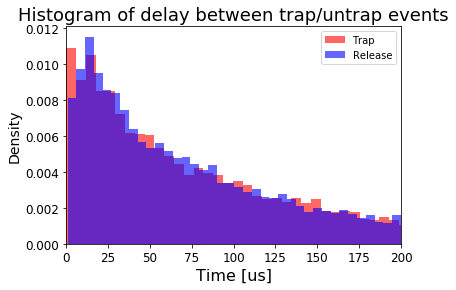

In [56]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.6,label='Trap',density=True)
hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
hw.set_title('Histogram of delay between trap/untrap events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
hw.set_xlim((0,200))
hw.legend()
plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

#### Now let's try to fit these

In [57]:
from scipy.optimize import curve_fit

In [203]:
def Pwait(t,a1,r1,a2,r2):
    return a1*np.exp(-r1*t) + a2*np.exp(-r2*t)

In [66]:
tBinCenters = (ht[1][1:] + ht[1][:-1])/2
rBinCenters = (hr[1][1:] + hr[1][:-1])/2

In [197]:
Tpars,Tcov = curve_fit(Pwait,tBinCenters,ht[0],[1,1/100.])

In [198]:
Tpars

array([0.0106459 , 0.01113087])

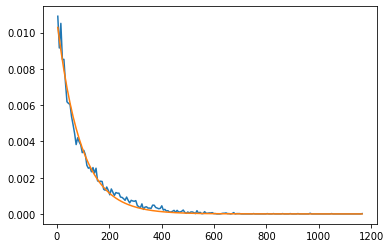

In [199]:
plt.plot(tBinCenters,ht[0],tBinCenters,Pwait(tBinCenters,*Tpars))

In [201]:
1/Tpars[1]

89.84022547138721

In [205]:
Rpars,Rcov = curve_fit(Pwait,rBinCenters,hr[0],[1,1/100,1,1/2000])

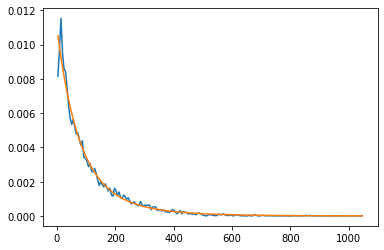

In [206]:
plt.plot(rBinCenters,hr[0],rBinCenters,Pwait(rBinCenters,*Rpars))

In [210]:
1/Rpars[1]

69.57721874015766

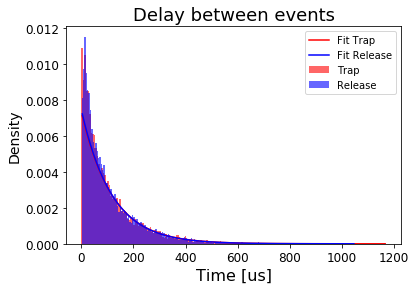

In [146]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.6,label='Trap',density=True)
hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
plt.plot(tBinCenters,Pwait(tBinCenters,*Tpars),'r',label='Fit Trap')
plt.plot(rBinCenters,Pwait(rBinCenters,*Rpars),'b',label='Fit Release')
hw.set_title('Delay between events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
hw.legend()
plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

#### We can see that this doesn't seem to fit the 200 to 500 region very well. Burst events will overpopulate the short wait times, so let's try fitting again but omitting the counts which are less than 100 us.

In [116]:
fit_id = np.where(rBinCenters > 100)

In [212]:
Tpars,Tcov = curve_fit(Pwait,tBinCenters,ht[0],[1,1/100.,1,1/50])

In [213]:
Rpars,Rcov = curve_fit(Pwait,rBinCenters,hr[0],[1,1/100.,1,1/50])

In [225]:
1/Tpars[3]

41.99646255469088

In [219]:
1/Rpars[3]

158.81165886793275

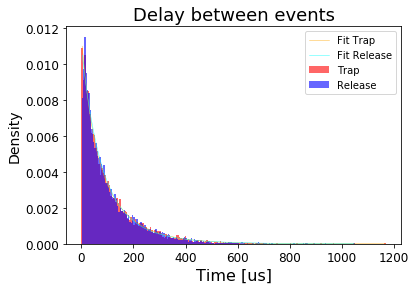

In [217]:
hw = plt.subplot()
ht = hw.hist(T_waits*1e6,bins=200,color='r',alpha=0.6,label='Trap',density=True)
hr = hw.hist(R_waits*1e6,bins=200,color='b',alpha=0.6,label='Release',density=True)
plt.plot(tBinCenters,Pwait(tBinCenters,*Tpars),'orange',label='Fit Trap',lw=0.5,alpha=0.8)
plt.plot(rBinCenters,Pwait(rBinCenters,*Rpars),'cyan',label='Fit Release',lw=0.5,alpha=0.8)
hw.set_title('Delay between events',fontsize = 18)
hw.set_xlabel('Time [us]',fontsize = 16)
hw.set_ylabel('Density',fontsize = 14)
hw.tick_params(labelsize=12)
hw.legend()
plt.savefig(r'E:\QPtrapperData\trapTimeHist.svg',format='svg')
plt.show()

#### We can try a double poisson process here to account for the burst events

### For now, let's look at the autocorrelation

In [122]:
from scipy.signal import correlate

In [161]:
def acorr(A):
    temp = correlate(A,A)
    temp = temp[int(temp.size/2):]
    return temp/temp[0]

In [173]:
tCorr = np.mean([acorr(a) for a in np.append(np.clip(events,0,1),0).reshape(100,int((events.size+1)/100))],axis=0)

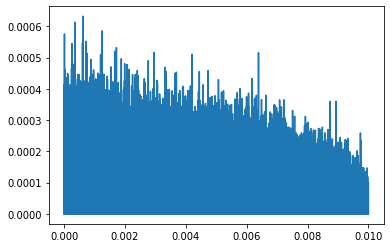

In [175]:
plt.plot(time[1:tCorr.size],tCorr[1:])

In [164]:
nCorr = np.mean([acorr(a) for a in nEst.reshape(100,int(nEst.size/100))],axis=0)

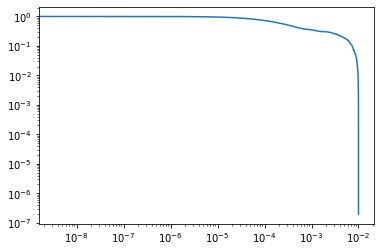

In [171]:
plt.loglog(time[:nCorr.size],nCorr)

In [176]:
resParams['fwhm']

1281386.3221938622